0

In [1]:
from setup import setup_src_path
print(setup_src_path())
import data.processed as processed
import config.config as config
import utils.setup as setup
import utils.functions as fn
from importlib import reload



['/home/guest/Desktop/projects/second-experiments/domain_adaptation_project/baselines', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/guest/Desktop/projects/second-experiments/.venv/lib/python3.8/site-packages', '/home/guest/Desktop/projects/second-experiments/domain_adaptation_project/modules']


/home/guest/Desktop/projects/second-experiments/.venv/lib/python3.8/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/guest/Desktop/projects/second-experiments/.venv/lib/python3.8/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
2024-05-24 00:40:29.215649: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-24 00:40:29.305335: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use availabl

In [5]:
from datasets import load_from_disk

source_data=load_from_disk(f"{config.Config.DATASETS_SAVE_PATH}/source_data")
source_data_eval=load_from_disk(f"{config.Config.DATASETS_SAVE_PATH}/source_data_eval")
target_data=load_from_disk(f"{config.Config.DATASETS_SAVE_PATH}/target_data")
target_data_eval=load_from_disk(f"{config.Config.DATASETS_SAVE_PATH}/target_data_eval")
test_target_data=load_from_disk(f"{config.Config.DATASETS_SAVE_PATH}/test_target_data")
raw_target_data=load_from_disk(f"{config.Config.DATASETS_SAVE_PATH}/raw_target_data")['train']


In [6]:
reload(fn)
print(fn.count_words(raw_target_data))
print(fn.count_sentences_basic(raw_target_data))

2273196
143135


In [7]:
from torch.utils.data import DataLoader
source_data_loader = DataLoader(source_data, batch_size=32, shuffle=True)
target_data_loader = DataLoader(target_data, batch_size=32)
source_data_eval_loader = DataLoader(source_data_eval, batch_size=32, shuffle=True)
target_data_eval_loader = DataLoader(target_data_eval, batch_size=32)

target_test_loader = DataLoader(test_target_data, batch_size=32)

In [8]:
from adapters import AutoAdapterModel,init
from tqdm import tqdm

from transformers import AutoConfig, AutoModelForMaskedLM

mdlcfg = AutoConfig.from_pretrained(
    config.Config.MODEL_NAME,
 
)
model = AutoModelForMaskedLM.from_pretrained(
    config.Config.MODEL_NAME,
)
reload(fn)
fn.print_trainable_parameters(model)

/home/guest/Desktop/projects/second-experiments/.venv/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


trainable params: 66985530 || all params: 66985530 || trainable%: 100.0


In [10]:
from transformers import AutoTokenizer

reload(processed)
tokenizer = AutoTokenizer.from_pretrained(config.Config.TOKENIZER_NAME)

tokenized_dataset= processed.tokenize_dataset(raw_target_data,tokenizer)
tokenized_dataset

/home/guest/Desktop/projects/second-experiments/.venv/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Dataset({
    features: ['input_ids', 'attention_mask', 'word_ids'],
    num_rows: 69615
})

In [11]:
chunk_size = 128
# Slicing produces a list of lists for each feature
tokenized_samples = tokenized_dataset[444:490]

#for idx, sample in enumerate(tokenized_samples["input_ids"]):
    #print(f"'>>> Review {idx} length: {len(sample)}'")

In [12]:
results = fn.group_texts(tokenized_samples, chunk_size)
for chunk in results["labels"]:
    print(f"'>>> Chunk length: {len(chunk)}'")

'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'


In [13]:
lm_datasets = tokenized_dataset.map(fn.group_texts, batched=True,fn_kwargs={'chunk_size': chunk_size})
lm_datasets

Dataset({
    features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
    num_rows: 24518
})

In [14]:
print(tokenizer.decode(lm_datasets[1]["input_ids"]))
print(tokenizer.decode(lm_datasets[1]['labels']))
print(len(lm_datasets[-1]['labels']))


12 buddhist temples and 3000 museums in the country. [SEP] [CLS] but go around the back of the taj, too, to the terrace which overlooks the yamuna river. [SEP] the taj has a terrace which looks over a river. [SEP] [CLS] a series of lenses and prisms projects a live image of the city onto a concave viewing screen inside the camera. [SEP] a series of lenses projects a live feed of the city onto the 50 foot screen. [SEP] [CLS] birdwatchers look out for over 270 species of birds which may be seen in the immediate area. [SEP] there are plenty of endangered birds for birdwatchers to find
12 buddhist temples and 3000 museums in the country. [SEP] [CLS] but go around the back of the taj, too, to the terrace which overlooks the yamuna river. [SEP] the taj has a terrace which looks over a river. [SEP] [CLS] a series of lenses and prisms projects a live image of the city onto a concave viewing screen inside the camera. [SEP] a series of lenses projects a live feed of the city onto the 50 foot scr

In [15]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)
samples = [lm_datasets[i] for i in range(2)]
for sample in samples:
    _ = sample.pop("word_ids")
dd=data_collator(samples)
for chunk in dd["input_ids"]:
    print(f"\n'>>> {tokenizer.decode(chunk)}'")

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



'>>> [CLS] the lake district national park was created in 1951 to preserve [MASK] entire landscape and allow public [MASK] to [MASK] of natural beauty. [SEP] lake district national park was the first national park established in 5 years. [SEP] [CLS] it was once regarded as the most beautiful street in europe, a claim that [MASK] difficult [MASK] understand today since so many of the original buildings have been replaced. [SEP] [MASK] many of the [MASK] buildings had been replaced by convenience stores. [SEP] [CLS] however, with over 1 [unused422] [MASK] buddhist temples, 200 shinto shrines, numerous museums, and [MASK] imperial [MASK] [MASK] [MASK] aware that you're not going to see everything. [SEP] there are only'

'>>> 12 buddhist temples and 3000 museums [MASK] the country. [SEP] [CLS] but go around the back of the taj, too, to the terrace which overlooks the yamuna river. [SEP] the taj has a terrace which [MASK] over a river. [SEP] [CLS] a [MASK] of lenses and prisms projects a l

In [16]:
reload(fn)
samples = [lm_datasets[i] for i in range(2)]
batch = fn.whole_word_masking_data_collator(samples,tokenizer)

for chunk in batch["input_ids"]:
    print(f"\n'>>> {tokenizer.decode(chunk)}'")


'>>> [CLS] the lake district national park was created in 1951 to [MASK] the entire landscape and allow public [MASK] to [MASK] [MASK] [MASK] beauty. [SEP] lake [MASK] national [MASK] [MASK] the first national park established in [MASK] years. [SEP] [CLS] it was once regarded [MASK] the most beautiful street in europe, a claim that is difficult [MASK] understand today since so many of the original [MASK] [MASK] [MASK] replaced. [SEP] so many of the original buildings had been replaced by convenience [MASK]. [SEP] [CLS] however, [MASK] over 1, 500 buddhist temples, 200 shinto shrines, numerous museums [MASK] and magnificent [MASK] palaces, be [MASK] that you're not going to see [MASK]. [SEP] there [MASK] only'

'>>> 12 buddhist temples and 3000 [MASK] [MASK] the country [MASK] [SEP] [CLS] but go around the back of the taj, too [MASK] [MASK] [MASK] terrace which overlooks the yamuna river. [SEP] the taj has a terrace which looks over a river. [SEP] [CLS] a [MASK] of lenses [MASK] prisms

In [17]:

downsampled_dataset = lm_datasets.train_test_split(
    test_size=0.1, seed=42
)
downsampled_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 22066
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 2452
    })
})

In [18]:

reload(fn)
trainer = fn.train_mlm_model_without_adapter(model,"full_model",data_collator,tokenizer, downsampled_dataset['train'],downsampled_dataset['test'])

/home/guest/Desktop/projects/second-experiments/.venv/lib/python3.8/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [19]:
import math

eval_results = trainer.evaluate()

print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

  0%|          | 0/77 [00:00<?, ?it/s]

>>> Perplexity: 21.12


In [20]:
trainer.train()

  0%|          | 0/6900 [00:00<?, ?it/s]

{'loss': 2.2393, 'learning_rate': 9.709375000000001e-05, 'epoch': 1.0}


  0%|          | 0/77 [00:00<?, ?it/s]

{'eval_loss': 1.9567559957504272, 'eval_runtime': 2.3055, 'eval_samples_per_second': 1063.551, 'eval_steps_per_second': 33.399, 'epoch': 1.0}
{'loss': 1.9711, 'learning_rate': 8.6328125e-05, 'epoch': 2.0}


  0%|          | 0/77 [00:00<?, ?it/s]

{'eval_loss': 1.7907402515411377, 'eval_runtime': 2.338, 'eval_samples_per_second': 1048.775, 'eval_steps_per_second': 32.935, 'epoch': 2.0}
{'loss': 1.8278, 'learning_rate': 7.55625e-05, 'epoch': 3.0}


  0%|          | 0/77 [00:00<?, ?it/s]

{'eval_loss': 1.7018787860870361, 'eval_runtime': 2.3116, 'eval_samples_per_second': 1060.741, 'eval_steps_per_second': 33.31, 'epoch': 3.0}
{'loss': 1.7153, 'learning_rate': 6.479687500000001e-05, 'epoch': 3.99}


  0%|          | 0/77 [00:00<?, ?it/s]

{'eval_loss': 1.6614524126052856, 'eval_runtime': 2.2803, 'eval_samples_per_second': 1075.278, 'eval_steps_per_second': 33.767, 'epoch': 4.0}
{'loss': 1.6336, 'learning_rate': 5.403125e-05, 'epoch': 4.99}


  0%|          | 0/77 [00:00<?, ?it/s]

{'eval_loss': 1.632625699043274, 'eval_runtime': 2.2671, 'eval_samples_per_second': 1081.543, 'eval_steps_per_second': 33.964, 'epoch': 5.0}
{'loss': 1.5565, 'learning_rate': 4.3265625e-05, 'epoch': 5.99}


  0%|          | 0/77 [00:00<?, ?it/s]

{'eval_loss': 1.5544445514678955, 'eval_runtime': 2.2671, 'eval_samples_per_second': 1081.546, 'eval_steps_per_second': 33.964, 'epoch': 6.0}
{'loss': 1.4982, 'learning_rate': 3.2500000000000004e-05, 'epoch': 6.99}


  0%|          | 0/77 [00:00<?, ?it/s]

{'eval_loss': 1.51703941822052, 'eval_runtime': 2.2672, 'eval_samples_per_second': 1081.491, 'eval_steps_per_second': 33.962, 'epoch': 7.0}
{'loss': 1.4522, 'learning_rate': 2.1734375e-05, 'epoch': 7.99}


  0%|          | 0/77 [00:00<?, ?it/s]

{'eval_loss': 1.478076457977295, 'eval_runtime': 2.2586, 'eval_samples_per_second': 1085.614, 'eval_steps_per_second': 34.091, 'epoch': 8.0}
{'loss': 1.4022, 'learning_rate': 1.096875e-05, 'epoch': 8.99}


  0%|          | 0/77 [00:00<?, ?it/s]

{'eval_loss': 1.460636019706726, 'eval_runtime': 2.2765, 'eval_samples_per_second': 1077.11, 'eval_steps_per_second': 33.824, 'epoch': 9.0}
{'loss': 1.378, 'learning_rate': 2.0312500000000001e-07, 'epoch': 9.99}


  0%|          | 0/77 [00:00<?, ?it/s]

{'eval_loss': 1.4589784145355225, 'eval_runtime': 2.2604, 'eval_samples_per_second': 1084.767, 'eval_steps_per_second': 34.065, 'epoch': 10.0}


There were missing keys in the checkpoint model loaded: ['vocab_projector.weight'].


{'train_runtime': 630.007, 'train_samples_per_second': 350.25, 'train_steps_per_second': 10.952, 'train_loss': 1.6669215357130853, 'epoch': 10.0}


TrainOutput(global_step=6900, training_loss=1.6669215357130853, metrics={'train_runtime': 630.007, 'train_samples_per_second': 350.25, 'train_steps_per_second': 10.952, 'train_loss': 1.6669215357130853, 'epoch': 10.0})

In [21]:
import math

eval_results = trainer.evaluate()

print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

  0%|          | 0/77 [00:00<?, ?it/s]

>>> Perplexity: 4.27


In [22]:
import torch
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
model.to(device)

from transformers import pipeline

mask_filler = pipeline("fill-mask", model=trainer.model, tokenizer=tokenizer)

In [23]:
masked_sentence = "I cancelled my [MASK]."
preds = mask_filler(masked_sentence)

for pred in preds:
    print(f">>> {pred['sequence']}")

>>> i cancelled my plans.
>>> i cancelled my trip.
>>> i cancelled my tour.
>>> i cancelled my visit.
>>> i cancelled my vacation.


In [24]:
best_checkpoint = trainer.state.best_model_checkpoint
print(f"Best model loaded from {best_checkpoint}")

Best model loaded from ../saved/results/full_model/results/checkpoint-6900


In [25]:
from transformers import DistilBertForSequenceClassification,DistilBertTokenizer

tokenizer = AutoTokenizer.from_pretrained(best_checkpoint)
model = AutoModelForMaskedLM.from_pretrained(best_checkpoint)
model = DistilBertForSequenceClassification.from_pretrained(best_checkpoint, num_labels=3)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ../saved/results/full_model/results/checkpoint-6900 and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
from transformers import TrainingArguments, Trainer, EvalPrediction, default_data_collator, EarlyStoppingCallback, get_cosine_schedule_with_warmup
from adapters import AdapterTrainer

eval_data = True
eval_data = source_data_eval
batch_size = 32

logging_steps = len(source_data) // batch_size

training_args = TrainingArguments(
    output_dir=f"{config.Config.RESULTS_SAVE_PATH}/full_model/results",  # Where to store the output (checkpoints and predictions)
    num_train_epochs=6,  # Total number of training epochs
    per_device_train_batch_size=batch_size,  # Batch size for training
    per_device_eval_batch_size=batch_size,  # Batch size for evaluation
    warmup_steps=500,  # Number of warmup steps for learning rate scheduler
    learning_rate=1e-4,
    weight_decay=0.01,  # Strength of weight decay
    logging_dir=f"{config.Config.RESULTS_SAVE_PATH}/full_model/logs",  # Directory for storing logs
    logging_steps=logging_steps,  # Log every X updates steps
    remove_unused_columns=False,
    evaluation_strategy="steps" if eval_data is not None else "no",  # Evaluate model every X steps
    eval_steps=logging_steps,  # Number of steps to perform evaluation
    save_steps=logging_steps,  # Save checkpoint every X steps
    save_total_limit=2,  # Limit the total amount of checkpoints
    load_best_model_at_end=True if eval_data is not None else False,  # Load the best model when finished training
    report_to="none"  # Do not report to any online service
)

# Adding Early Stopping
callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]

trainer = Trainer(
    model=model,  # The instantiated 🤗 Transformers model to be trained
    args=training_args,  # Training arguments, defined above
    train_dataset=source_data,  # Training dataset
    eval_dataset=eval_data if eval_data is not None else None,
    callbacks=callbacks
)

# Create the optimizer and scheduler
trainer.create_optimizer_and_scheduler(num_training_steps=len(source_data) * training_args.num_train_epochs // batch_size)

# Get the optimizer and replace its scheduler with the custom one
optimizer = trainer.optimizer
total_steps = len(source_data) * training_args.num_train_epochs // batch_size
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=training_args.warmup_steps, num_training_steps=total_steps)

trainer.lr_scheduler = scheduler

# Train the model
# trainer.train()


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/home/guest/Desktop/projects/second-experiments/.venv/lib/python3.8/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [27]:
total_steps

14064

In [28]:
trainer.train()


  0%|          | 0/14070 [00:00<?, ?it/s]

{'loss': 0.7658, 'learning_rate': 8.642593957258659e-05, 'epoch': 1.0}


  0%|          | 0/242 [00:00<?, ?it/s]

{'eval_loss': 0.7482477426528931, 'eval_runtime': 7.253, 'eval_samples_per_second': 1066.46, 'eval_steps_per_second': 33.366, 'epoch': 1.0}
{'loss': 0.5399, 'learning_rate': 6.915991156963891e-05, 'epoch': 2.0}


  0%|          | 0/242 [00:00<?, ?it/s]

{'eval_loss': 0.7132567167282104, 'eval_runtime': 7.2337, 'eval_samples_per_second': 1069.304, 'eval_steps_per_second': 33.455, 'epoch': 2.0}
{'loss': 0.3699, 'learning_rate': 5.189388356669124e-05, 'epoch': 3.0}


  0%|          | 0/242 [00:00<?, ?it/s]

{'eval_loss': 0.8270351886749268, 'eval_runtime': 7.2449, 'eval_samples_per_second': 1067.653, 'eval_steps_per_second': 33.403, 'epoch': 3.0}
{'loss': 0.2226, 'learning_rate': 3.4627855563743555e-05, 'epoch': 4.0}


  0%|          | 0/242 [00:00<?, ?it/s]

{'eval_loss': 1.0716365575790405, 'eval_runtime': 7.2159, 'eval_samples_per_second': 1071.945, 'eval_steps_per_second': 33.537, 'epoch': 4.0}
{'loss': 0.1272, 'learning_rate': 1.7369196757553426e-05, 'epoch': 5.0}


  0%|          | 0/242 [00:00<?, ?it/s]

{'eval_loss': 1.273061752319336, 'eval_runtime': 7.2523, 'eval_samples_per_second': 1066.551, 'eval_steps_per_second': 33.369, 'epoch': 5.0}
{'train_runtime': 1393.4475, 'train_samples_per_second': 322.996, 'train_steps_per_second': 10.097, 'train_loss': 0.40508472585840843, 'epoch': 5.0}


TrainOutput(global_step=11720, training_loss=0.40508472585840843, metrics={'train_runtime': 1393.4475, 'train_samples_per_second': 322.996, 'train_steps_per_second': 10.097, 'train_loss': 0.40508472585840843, 'epoch': 5.0})

In [29]:
test_target_data

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 1976
})

In [30]:
import numpy as np
from transformers import EvalPrediction
from sklearn.metrics import accuracy_score, f1_score,precision_recall_fscore_support


def compute_metrics(pred:EvalPrediction):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }
eval_trainer = AdapterTrainer(
    model=model,
    args=TrainingArguments(output_dir="./eval_output", remove_unused_columns=False,),
    eval_dataset=test_target_data,
    compute_metrics=compute_metrics,
)
eval_trainer.evaluate()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/home/guest/Desktop/projects/second-experiments/.venv/lib/python3.8/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


  0%|          | 0/247 [00:00<?, ?it/s]

{'eval_loss': 0.7214413285255432,
 'eval_accuracy': 0.7105263157894737,
 'eval_f1': 0.7129746152528041,
 'eval_precision': 0.7339460111210847,
 'eval_recall': 0.7105263157894737,
 'eval_runtime': 4.069,
 'eval_samples_per_second': 485.625,
 'eval_steps_per_second': 60.703}

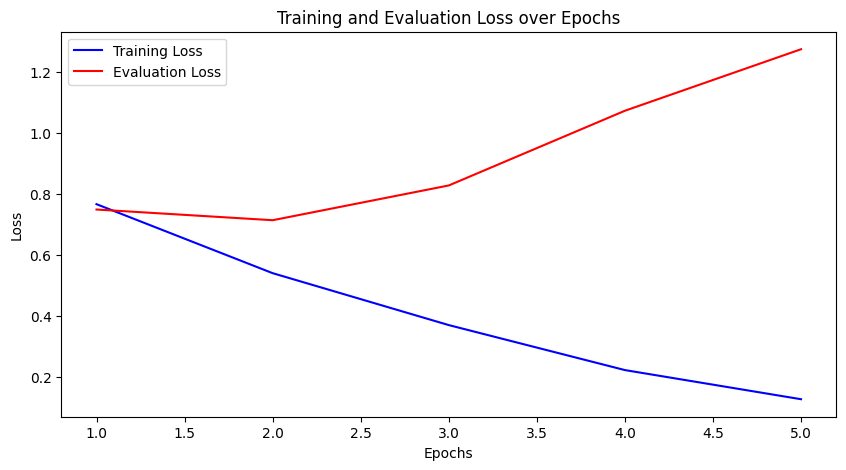

In [31]:
import matplotlib.pyplot as plt

# Sample log history from trainer.state.log_history
log_history = trainer.state.log_history

# Extract training and evaluation losses
epochs = []
training_losses = []
evaluation_losses = []

for record in log_history:
    if "loss" in record and "epoch" in record:
        epochs.append(record["epoch"])
        training_losses.append(record["loss"])
    if "eval_loss" in record and "epoch" in record:
        evaluation_losses.append(record["eval_loss"])

# Plot the training and evaluation loss curves
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_losses, 'b', label='Training Loss')
plt.plot(epochs[:len(evaluation_losses)], evaluation_losses, 'r', label='Evaluation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss over Epochs')
plt.legend()
plt.show()
